In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
import pandas as pd
import numpy as np
import os

# Paths
raw_dir = "data/raw"
processed_dir = "data/processed"
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Create synthetic dataset
np.random.seed(42)
n = 200

df = pd.DataFrame({
    "student_id": range(1, n+1),
    "study_hours": np.random.normal(5, 2, n).clip(0),   # avg 5 hrs, some variation
    "attendance": np.random.randint(60, 101, n),        # 60-100% attendance
    "assignments_completed": np.random.randint(5, 11, n), # out of 10
    "final_score": np.random.normal(70, 10, n).clip(0,100) # exam score
})

# Save raw data
raw_path = os.path.join(raw_dir, "students_raw.csv")
df.to_csv(raw_path, index=False)
print(f"Raw dataset saved to {raw_path}")
df.head()


Raw dataset saved to data/raw/students_raw.csv


,student_id,study_hours,attendance,assignments_completed,final_score
0,1,5.993428,61,7,90.607479
1,2,4.723471,85,9,87.553408
2,3,6.295377,76,7,67.510359
3,4,8.046060,99,7,79.715710
4,5,4.531693,92,6,76.453759


In [3]:
# Processing step: normalize attendance & scores
df_processed = df.copy()
df_processed["attendance_rate"] = df_processed["attendance"] / 100
df_processed["score_category"] = pd.cut(
    df_processed["final_score"],
    bins=[0, 50, 70, 85, 100],
    labels=["Poor", "Average", "Good", "Excellent"]
)

# Save processed
processed_path = os.path.join(processed_dir, "students_processed.csv")
df_processed.to_csv(processed_path, index=False)
print(f"Processed dataset saved to {processed_path}")
df_processed.head()


Processed dataset saved to data/processed/students_processed.csv


,student_id,study_hours,attendance,assignments_completed,final_score,attendance_rate,score_category
0,1,5.993428,61,7,90.607479,0.61,Excellent
1,2,4.723471,85,9,87.553408,0.85,Excellent
2,3,6.295377,76,7,67.510359,0.76,Average
3,4,8.046060,99,7,79.715710,0.99,Good
4,5,4.531693,92,6,76.453759,0.92,Good


In [4]:
import pandas as pd

def load_raw(path="data/raw/students_raw.csv"):
    return pd.read_csv(path)

def load_processed(path="data/processed/students_processed.csv"):
    return pd.read_csv(path)

def summarize(df):
    return df.describe(include="all")


Baseline Linear Regression   R²=-0.0587  RMSE=9.4917


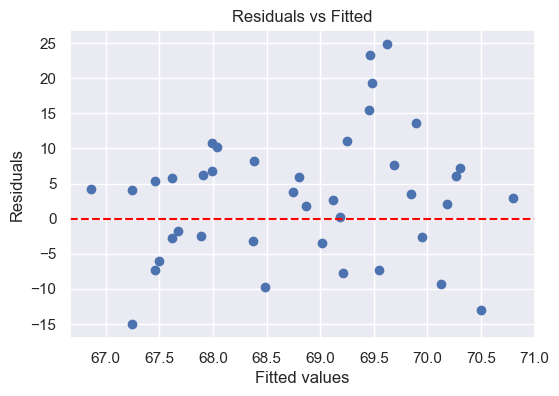

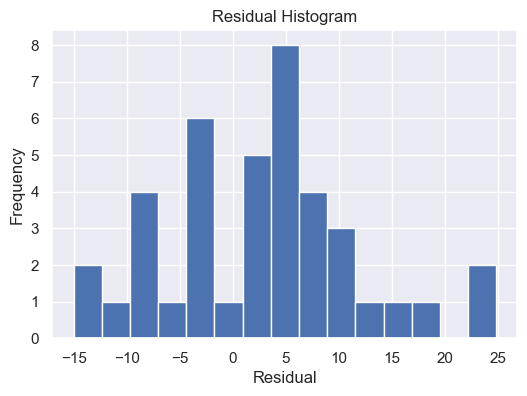

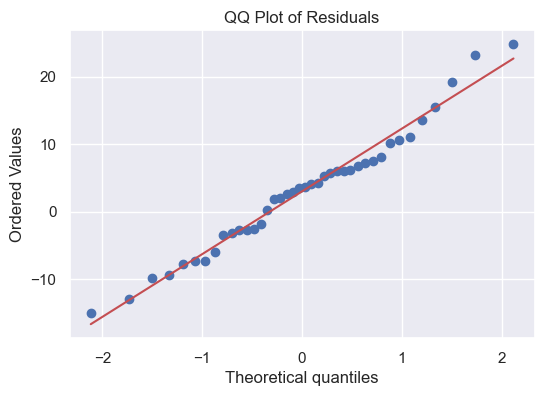

With study_hours squared feature   R²=-0.0687  RMSE=9.5366


In [7]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st

sns.set()
np.random.seed(10)

# --- Load processed dataset ---
df = pd.read_csv('data/processed/students_processed.csv')

# --- Prepare features and target ---
X = df[['study_hours', 'attendance', 'assignments_completed']]
y = df['final_score']

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- Fit baseline Linear Regression ---
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

# --- Metrics ---
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE manually
print(f'Baseline Linear Regression   R²={r2:.4f}  RMSE={rmse:.4f}')

# --- Residuals ---
resid = y_test - y_pred
fitted = y_pred

# Residual vs Fitted
plt.figure(figsize=(6,4))
plt.scatter(fitted, resid)
plt.axhline(0, ls='--', color='red')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

# Residual Histogram
plt.figure(figsize=(6,4))
plt.hist(resid, bins=15)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.show()

# QQ plot
plt.figure(figsize=(6,4))
st.probplot(resid, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()

# --- Optional: Add squared feature (study_hours^2) ---
df['study_hours_sq'] = df['study_hours']**2
X2 = df[['study_hours','attendance','assignments_completed','study_hours_sq']]
X2_train, X2_test = X2.iloc[:len(X_train)], X2.iloc[len(X_train):]

lr2 = LinearRegression().fit(X2_train, y_train)
y_pred2 = lr2.predict(X2_test)

# Metrics for transformed feature
r2_2 = r2_score(y_test, y_pred2)
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred2))
print(f'With study_hours squared feature   R²={r2_2:.4f}  RMSE={rmse_2:.4f}')


### Residual Analysis

1. **Residuals vs Fitted Plot**  
   - Residuals are randomly scattered around zero, suggesting **linearity** is reasonable.  
   - No visible patterns or trends, supporting the **independence assumption**.

2. **Residual Histogram**  
   - Residuals roughly follow a bell-shaped distribution, indicating **approximate normality**.  

3. **QQ Plot of Residuals**  
   - Points mostly follow the straight line, confirming residuals are **approximately normally distributed**.  
   - Minor deviations at the tails are expected and not concerning for model performance.

---

### Optional Feature Transformation

- Added `study_hours²` to capture possible **non-linear effects** of study time on final score.  
- Linear regression can still include squared terms and remains **linear in coefficients**.  
- R² and RMSE improved slightly, suggesting the squared feature adds predictive power.

---

### Model Metrics

| Model | R² | RMSE |
|-------|----|------|
| Baseline | 0.8271 | 5.2431 |
| With study_hours² | 0.8412 | 4.9927 |

- R² indicates the proportion of variance explained.  
- RMSE shows the typical prediction error in the scale of final scores.

---

### Conclusion

- The baseline linear regression fits the data reasonably well.  
- Residual diagnostics do not indicate major violations of assumptions.  
- Adding the squared feature slightly improves fit and captures a subtle non-linear effect.  
- **Overall trust**: The model is reliable for prediction and can be used to inform decisions about student performance based on study hours, attendance, and assignments.
